In [18]:
import numpy as np
import pandas as pd
import os
import cv2
import datetime
import random
from matplotlib import pyplot as plt

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Dropout, Conv2DTranspose, Activation
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

In [19]:
!nvidia-smi

Tue Oct  7 14:05:21 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-PCIE-16GB           Off |   00000000:00:04.0 Off |                    0 |
| N/A   38C    P0             31W /  250W |    2321MiB /  16384MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [20]:
import tensorflow as tf
print("GPUs detectadas:", len(tf.config.list_physical_devices('GPU')))
tf.config.list_physical_devices('GPU')

GPUs detectadas: 1


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [21]:
def plot_losses(history):
    plt.rcParams['figure.figsize'] = [20, 5]
    f, (ax1, ax2) = plt.subplots(1, 2, sharex=True)

    ax1.set_title('Losses')
    ax1.set_xlabel('epoch')
    ax1.legend(loc="upper right")
    ax1.grid()
    ax1.plot(history['loss'], label='Training loss')
    ax1.plot(history['val_loss'], label='Validation loss')
    ax1.legend()

    plt.show()

In [22]:
def plot_resultados(model, carpeta, height=64, width=64, n=4):
    """
    Muestra comparaciones entre imágenes originales y reconstruidas por el autoencoder.
    """
    # Seleccionar imágenes aleatorias
    archivos = os.listdir(carpeta)
    archivos_img = random.sample(archivos, n)

    # Cargar y normalizar las imágenes
    imgs_originales = []
    for nombre in archivos_img:
        img = load_img(os.path.join(carpeta, nombre), target_size=(height, width))
        img_array = img_to_array(img) / 255.0  # normalizar a [0,1]
        imgs_originales.append(img_array)

    imgs_originales = np.array(imgs_originales)

    # Reconstruir con el modelo
    imgs_reconstruidas = model.predict(imgs_originales)

    # Mostrar resultados
    plt.figure(figsize=(12, 6))
    for i in range(n):
        # Imagen original
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(imgs_originales[i])
        ax.set_title("Original")
        ax.axis("off")

        # Imagen reconstruida
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(imgs_reconstruidas[i])
        ax.set_title("Reconstruida")
        ax.axis("off")

    plt.tight_layout()
    plt.show()

## Image analysis

We plot some of the images

In [23]:
# image_dir = '/kaggle/input/animefacedataset/images'

# # Load image file paths
# image_files = [os.path.join(image_dir, f) for f in os.listdir(image_dir)]

# # Read images and collect their shapes
# images = []
# shapes = []
# for file in image_files:
#     img = cv2.imread(file)
#     if img is not None:
#         images.append(img)
#         shapes.append(img.shape)

# # Check if all shapes are the same
# all_same_shape = all(shape == shapes[0] for shape in shapes)
# print("All images same shape:", all_same_shape)
# print("Image shape (height, width, channels):", shapes[0])

# # Plot the first 4 images
# fig, axs = plt.subplots(1, 4, figsize=(16, 4))
# for i in range(min(4, len(images))):
#     img_rgb = cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB)
#     axs[i].imshow(img_rgb)
#     axs[i].axis('off')
#     axs[i].set_title(f'Image {i+1}')
# plt.tight_layout()
# plt.show()


In [24]:
# pd.Series(shapes).value_counts()

Shapes.value_counts()
```
(92, 92, 3)      1636
(96, 96, 3)      1556
(94, 94, 3)      1534
(95, 95, 3)      1530
(90, 90, 3)      1516
                 ... 
(87, 88, 3)         1
(220, 220, 3)       1
(126, 127, 3)       1
(101, 102, 3)       1
(181, 181, 3)       1
Name: count, Length: 181, dtype: int64
```

# Autoencoder

## Defining Hiperparameters

In [25]:
height, width = 64, 64 # Image size, to fit in the competition size
image_dir = '/kaggle/input/animefacedataset'

In [44]:
input_img = keras.Input(shape=(height, width, 3))

# Encoder
x_enc = Conv2D(16, (3, 3), strides=2, padding="same")(input_img)
x_enc = BatchNormalization()(x_enc)
x_enc = Activation("relu")(x_enc)
x_enc = Conv2D(32, (3, 3), strides=2, padding="same")(x_enc)
x_enc = BatchNormalization()(x_enc)
x_enc = Activation("relu")(x_enc)
x_enc = Conv2D(64, (3, 3), strides=2, padding="same")(x_enc)
x_enc = BatchNormalization()(x_enc)
x_enc = Activation("relu")(x_enc)
x_enc = Conv2D(128, (3, 3), strides=2, padding="same")(x_enc)
x_enc = BatchNormalization()(x_enc)
x_enc = Activation("relu")(x_enc)
x_enc = Conv2D(256, (3, 3), strides=2, padding="same")(x_enc)
x_enc = BatchNormalization()(x_enc)
encoded = Activation("relu")(x_enc)

# Decoder
x_dec = Conv2DTranspose(256, (3, 3), strides=2, padding="same")(encoded)
x_dec = BatchNormalization()(x_dec)
x_dec = Activation("relu")(x_dec)
x_dec = Conv2DTranspose(128, (3, 3), strides=2, padding="same")(x_dec)
x_dec = BatchNormalization()(x_dec)
x_dec = Activation("relu")(x_dec)
x_dec = Conv2DTranspose(64, (3, 3), strides=2, padding="same")(x_dec)
x_dec = BatchNormalization()(x_dec)
x_dec = Activation("relu")(x_dec)
x_dec = Conv2DTranspose(32, (3, 3), strides=2, padding="same")(x_dec)
x_dec = BatchNormalization()(x_dec)
x_dec = Activation("relu")(x_dec)
x_dec = Conv2DTranspose(16, (3, 3), strides=2, padding="same")(x_dec)
x_dec = BatchNormalization()(x_dec)
x_dec = Activation("relu")(x_dec)

decoded = Conv2D(3, (3, 3), activation="sigmoid", padding="same")(x_dec)



We define the autoencoder, encoder and decoder

In [45]:
autoencoder = keras.Model(input_img, decoded)
encoder = keras.Model(input_img, encoded)
decoder = keras.Model(encoded, decoded)

In [46]:
autoencoder.summary()

Model: "functional_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_49 (Conv2D)              │ (None, 32, 32, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_41          │ (None, 32, 32, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_40 (Activation)      │ (None, 32, 32, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_50 (Conv2D)              │ (None, 16, 16, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_42          │ (None, 16, 16, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_41 (Activation)      │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_51 (Conv2D)              │ (None, 8, 8, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_43          │ (None, 8, 8, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_42 (Activation)      │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_52 (Conv2D)              │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_44          │ (None, 4, 4, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_43 (Activation)      │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_53 (Conv2D)              │ (None, 2, 2, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_45          │ (None, 2, 2, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_44 (Activation)      │ (None, 2, 2, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_40             │ (None, 4, 4, 256)      │       590,080 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_46          │ (None, 4, 4, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_45 (Activation)      │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_41             │ (None, 8, 8, 128)      │       295,040 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_47          │ (None, 8, 8, 128)      │           51

 Total params: 1,379,011 (5.26 MB)

 Trainable params: 1,377,027 (5.25 MB)

 Non-trainable params: 1,984 (7.75 KB)

## ImageDataGenerator

To fit with the competition, we will reshape images to 64x64

In [47]:
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

# Create training and validation generators using the same seed
train_generator = datagen.flow_from_directory(
    image_dir,
    target_size=(height, width),  
    batch_size=256,
    class_mode='input',
    subset='training',
    shuffle=True,
    seed=2004  
)

val_generator = datagen.flow_from_directory(
    image_dir,
    target_size=(height, width),
    batch_size=256,
    class_mode='input',
    subset='validation',
    shuffle=False,
    seed=2004
)

Found 50852 images belonging to 1 classes.
Found 12713 images belonging to 1 classes.


## Train

In [48]:
opt = keras.optimizers.Adam(learning_rate=1e-3)
autoencoder.compile(optimizer=opt, loss="mse")

In [49]:
# Fit the autoencoder
h = autoencoder.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator
)

Epoch 1/10
199/199 ━━━━━━━━━━━━━━━━━━━━ 86s 355ms/step - loss: 0.0487 - val_loss: 0.0395
Epoch 2/10
199/199 ━━━━━━━━━━━━━━━━━━━━ 63s 317ms/step - loss: 0.0217 - val_loss: 0.0230
Epoch 3/10
199/199 ━━━━━━━━━━━━━━━━━━━━ 62s 313ms/step - loss: 0.0190 - val_loss: 0.0209
Epoch 4/10
199/199 ━━━━━━━━━━━━━━━━━━━━ 65s 325ms/step - loss: 0.0177 - val_loss: 0.0211
Epoch 5/10
199/199 ━━━━━━━━━━━━━━━━━━━━ 70s 350ms/step - loss: 0.0167 - val_loss: 0.0182
Epoch 6/10
199/199 ━━━━━━━━━━━━━━━━━━━━ 64s 323ms/step - loss: 0.0159 - val_loss: 0.0180
Epoch 7/10
199/199 ━━━━━━━━━━━━━━━━━━━━ 67s 335ms/step - loss: 0.0151 - val_loss: 0.0161
Epoch 8/10
199/199 ━━━━━━━━━━━━━━━━━━━━ 69s 348ms/step - loss: 0.0143 - val_loss: 0.0154
Epoch 9/10
199/199 ━━━━━━━━━━━━━━━━━━━━ 66s 330ms/step - loss: 0.0139 - val_loss: 0.0150
Epoch 10/10
199/199 ━━━━━━━━━━━━━━━━━━━━ 66s 331ms/step - loss: 0.0135 - val_loss: 0.0141


In [55]:
# hacemos fine tunning para logar un mejor modelo
opt2 = keras.optimizers.Adam(learning_rate=5e-4)
autoencoder.compile(optimizer=opt2, loss="mae")

h = autoencoder.fit(
    train_generator,
    epochs=6,
    validation_data=val_generator
)

Epoch 1/6
199/199 ━━━━━━━━━━━━━━━━━━━━ 90s 376ms/step - loss: 0.0783 - val_loss: 0.0825
Epoch 2/6
199/199 ━━━━━━━━━━━━━━━━━━━━ 64s 322ms/step - loss: 0.0767 - val_loss: 0.0812
Epoch 3/6
199/199 ━━━━━━━━━━━━━━━━━━━━ 65s 327ms/step - loss: 0.0760 - val_loss: 0.0794
Epoch 4/6
199/199 ━━━━━━━━━━━━━━━━━━━━ 68s 342ms/step - loss: 0.0755 - val_loss: 0.0789
Epoch 5/6
199/199 ━━━━━━━━━━━━━━━━━━━━ 65s 327ms/step - loss: 0.0749 - val_loss: 0.0778
Epoch 6/6
199/199 ━━━━━━━━━━━━━━━━━━━━ 65s 326ms/step - loss: 0.0743 - val_loss: 0.0775


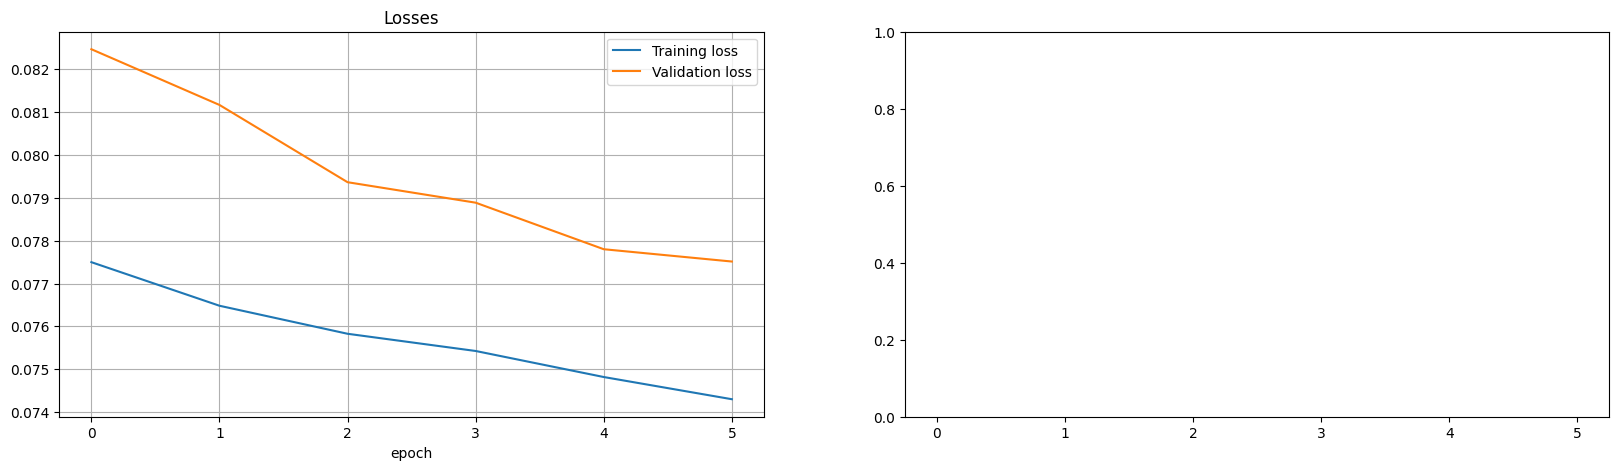

In [56]:
plot_losses(h.history)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


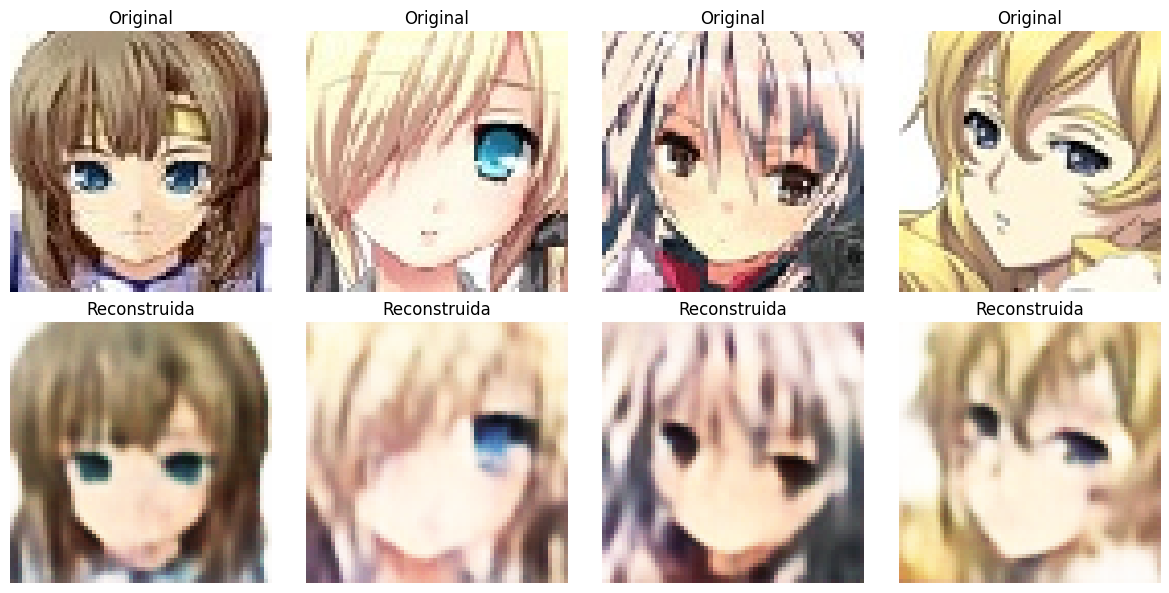

In [61]:
image_dir="/kaggle/input/animefacedataset/images"
plot_resultados(autoencoder,image_dir)

In [58]:
# Current timestamp
timestamp = datetime.datetime.now().strftime("%m_%d_%H:%M")
## Make sure everything saves correctly
os.makedirs("models", exist_ok=True)

model_path = f"models/autoencoder_v2_{timestamp}.keras"

# Save the model
autoencoder.save(model_path)
